### Import Packages

In [1]:
#load packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing, tree, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, roc_curve, auc, average_precision_score, ConfusionMatrixDisplay, precision_recall_fscore_support 


#install dataset package
#!pip install --quiet dmba
#import dmba

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA


# Steps

**1. Read Data**

**2. Pre-Process and aggregate the data**

**3. Split variables into different groups**

**4. Perform Dimensionality Reduction in each group**

**5. Split data into train-test and validation**

**6. Build Classifier Model and perform daignostics**

**7. Hyper parameter tuning using Grid Search**

**8. Model Validation**

**9. Results**


### Load Data

In [2]:
### Loading Data
#load data
amex_data = pd.read_feather('/kaggle/input/amexfeather/train_data.ftr')
print("The shape with the categorical features is:", amex_data.shape)

#get labels
amex_labels = amex_data[['customer_ID', 'target']] #pd.read_csv('/kaggle/input/amex-default-prediction/train_labels.csv').iloc[:,1]z
amex_labels = amex_labels.groupby('customer_ID').agg({'target' : 'min'})
print("The shape of the data labels is:", amex_labels.shape)


#load test data
#test_data = pd.read_parquet('/kaggle/input/amex-parquet/test_data.parquet')
#print("The shape with the categorical features is:", test_data.shape)


The shape with the categorical features is: (5531451, 191)
The shape of the data labels is: (458913, 1)


In [3]:
amex_data.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938477,0.001734,0.008728,1.006836,0.009224,0.124023,0.008774,0.004707,...,NaN,NaN,0.002426,0.003706,0.003819,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936523,0.005775,0.004925,1.000977,0.006153,0.126709,0.000798,0.002714,...,NaN,NaN,0.003956,0.003166,0.005032,NaN,0.009575,0.005493,0.009216,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954102,0.091492,0.021652,1.009766,0.006817,0.123962,0.007599,0.009422,...,NaN,NaN,0.003269,0.007328,0.000427,NaN,0.003429,0.006985,0.002604,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960449,0.002455,0.013687,1.002930,0.001372,0.117188,0.000685,0.005531,...,NaN,NaN,0.006119,0.004517,0.003201,NaN,0.008423,0.006527,0.009598,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947266,0.002483,0.015190,1.000977,0.007607,0.117310,0.004654,0.009308,...,NaN,NaN,0.003672,0.004944,0.008888,NaN,0.001670,0.008125,0.009827,0


In [4]:
len(amex_data.customer_ID.unique())

458913

<a id="5"></a>
# <div style='display:fill;color:#dfe3e8;background-color:#053673;padding:20px'>   <b> DATA PRE-PROCESSING </b> </div>

### Remove categorical variables

In [5]:
CATEGORICAL_FEATURES = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]

#remove catagorical features
amex_data = amex_data.drop(CATEGORICAL_FEATURES, axis=1)
amex_data = amex_data.drop(['target'], axis=1)
print("The train data shape without the categorical features is:", amex_data.shape)


The train data shape without the categorical features is: (5531451, 179)


### Removing columns with high Missing Data

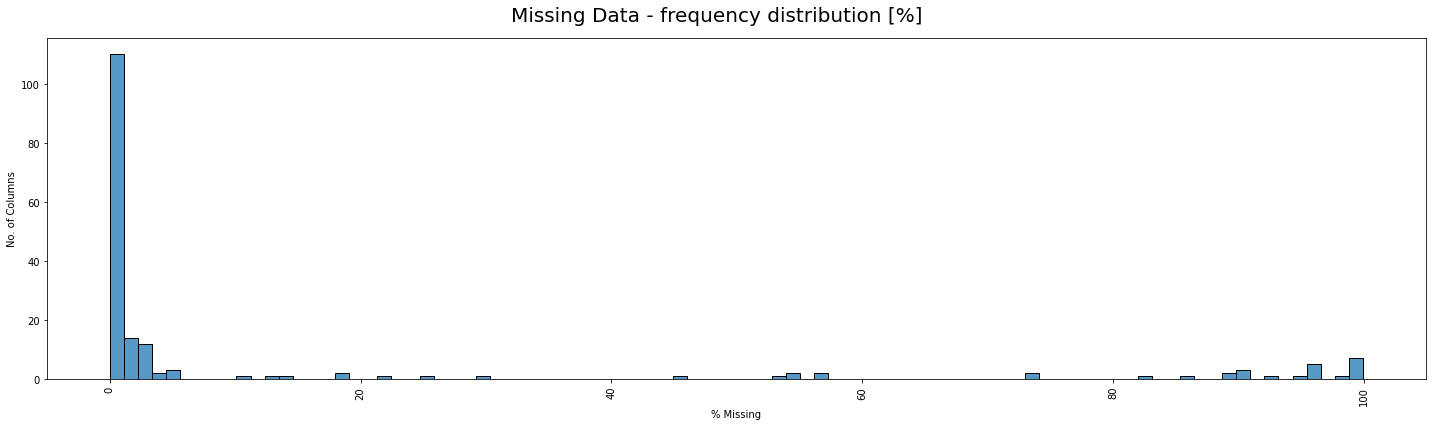

In [6]:
import seaborn as sns
missing_data=pd.DataFrame((amex_data.isnull().sum()/len(amex_data))*100, columns=['% Missing'])
fig, ax = plt.subplots(1,1, figsize=(20,6))
sns.histplot(data=missing_data, x="% Missing")
ax.set_ylabel('No. of Columns')
ax.tick_params(axis='x', rotation=90)
plt.suptitle("Missing Data - frequency distribution [%]", fontsize = 20)
plt.tight_layout()
plt.show()

In [7]:
missing_data=pd.DataFrame((amex_data.isnull().sum()/len(amex_data))*100, columns=['% Missing'])

cols_with_high_missing_data = list(missing_data[missing_data["% Missing"] >80].index)
amex_data = amex_data.drop(cols_with_high_missing_data, axis=1)
print("Follwing columns have been removed from the dataset:", cols_with_high_missing_data)
print("The amex data shape after removing features with high missing data is:", amex_data.shape)

Follwing columns have been removed from the dataset: ['D_42', 'D_49', 'D_73', 'D_76', 'R_9', 'B_29', 'D_87', 'D_88', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']
The amex data shape after removing features with high missing data is: (5531451, 157)


### Identifying other non-numeric columns (like date) and removing them
We notice that S_2 is a date varibale. We will aggregate the varibales to remove the time-component. Hence, we remoce the variable S_2

In [8]:
print('Non-numeric variables:', set(amex_data.columns) - set(amex_data._get_numeric_data().columns))
amex_data = amex_data.drop(['S_2'], axis=1)
print("The amex data shape after eliminating date variables:", amex_data.shape)

Non-numeric variables: {'S_2', 'customer_ID'}
The amex data shape after eliminating date variables: (5531451, 156)


### DATA AGGREGATION

In [9]:
aggregation_dict = dict.fromkeys(list(set(amex_data.columns) - set(['customer_ID'])), "mean")
agg_amex_data = amex_data.groupby(['customer_ID']).agg(aggregation_dict)
agg_amex_data.head(5)

,B_16,R_5,D_144,D_83,D_84,B_10,D_70,D_127,B_40,D_107,...,S_11,S_26,P_2,S_27,R_27,D_125,R_24,D_124,B_7,S_6
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.004768,0.004684,0.005283,0.004890,0.004944,0.270264,0.005222,1.005859,0.087280,0.672363,...,0.469971,0.012558,0.933594,0.851074,1.005859,0.006252,0.005470,0.686523,0.036621,0.004646
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.076477,0.005795,0.004219,0.003975,0.004299,0.298828,0.004143,0.080627,0.022125,0.005859,...,0.375488,0.004070,0.899902,0.134033,1.005859,0.004238,0.004028,0.140381,0.028046,0.003820
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.012482,0.005684,0.005112,0.005276,0.005062,0.273682,0.004574,0.005184,0.027405,0.005379,...,0.285156,0.005924,0.878418,NaN,1.004883,0.004742,0.004093,0.276611,0.034424,1.005859
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.095581,0.005081,0.004768,0.006462,0.005054,0.306641,0.005039,0.003635,0.073792,0.005642,...,0.303223,0.019455,0.599121,0.516113,1.004883,0.004311,0.004715,0.606934,0.062134,0.005524
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.004345,0.005833,0.004379,0.003983,0.005344,0.100342,0.121460,0.005558,0.149048,1.005859,...,0.307861,0.003868,0.891602,NaN,1.005859,0.004639,0.004959,0.186646,0.115295,0.850586


In [10]:
# Missing value treatment - Filling missing data with corresponding column Median
for column in agg_amex_data.columns:
    median = agg_amex_data[column].median()
    agg_amex_data[column] = agg_amex_data[column].fillna(median)
    
    
agg_amex_data.head(5)    

,B_16,R_5,D_144,D_83,D_84,B_10,D_70,D_127,B_40,D_107,...,S_11,S_26,P_2,S_27,R_27,D_125,R_24,D_124,B_7,S_6
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.004768,0.004684,0.005283,0.004890,0.004944,0.270264,0.005222,1.005859,0.087280,0.672363,...,0.469971,0.012558,0.933594,0.851074,1.005859,0.006252,0.005470,0.686523,0.036621,0.004646
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.076477,0.005795,0.004219,0.003975,0.004299,0.298828,0.004143,0.080627,0.022125,0.005859,...,0.375488,0.004070,0.899902,0.134033,1.005859,0.004238,0.004028,0.140381,0.028046,0.003820
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.012482,0.005684,0.005112,0.005276,0.005062,0.273682,0.004574,0.005184,0.027405,0.005379,...,0.285156,0.005924,0.878418,0.263916,1.004883,0.004742,0.004093,0.276611,0.034424,1.005859
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.095581,0.005081,0.004768,0.006462,0.005054,0.306641,0.005039,0.003635,0.073792,0.005642,...,0.303223,0.019455,0.599121,0.516113,1.004883,0.004311,0.004715,0.606934,0.062134,0.005524
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.004345,0.005833,0.004379,0.003983,0.005344,0.100342,0.121460,0.005558,0.149048,1.005859,...,0.307861,0.003868,0.891602,0.263916,1.005859,0.004639,0.004959,0.186646,0.115295,0.850586


<a id="5"></a>
# <div style='display:fill;color:#dfe3e8;background-color:#053673;padding:20px'>   <b> Feature Engineering & Feature Selection</b> </div>

### DIMENSIONALITY REDUCTION

In [11]:
## Grouping columns by categories

Deliquency_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='D']
Spend_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='S']
Payment_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='P']
Balance_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='B']
Risk_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='R']

### **Deliquency**

In [12]:
len(Deliquency_variables)

70

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70
Standard deviation,11.4405,0.8452,0.7339,0.6129,0.5995,0.4914,0.4702,0.4416,0.3928,0.3622,...,0.0571,0.0491,0.0431,0.0386,0.0181,0.0143,0.013,0.0064,0.0057,0.0031
Proportion of variance,0.9673,0.0053,0.0040,0.0028,0.0027,0.0018,0.0016,0.0014,0.0011,0.0010,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000
Cumulative proportion,0.9673,0.9725,0.9765,0.9793,0.9820,0.9837,0.9854,0.9868,0.9880,0.9889,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.000,1.0000,1.0000,1.0000


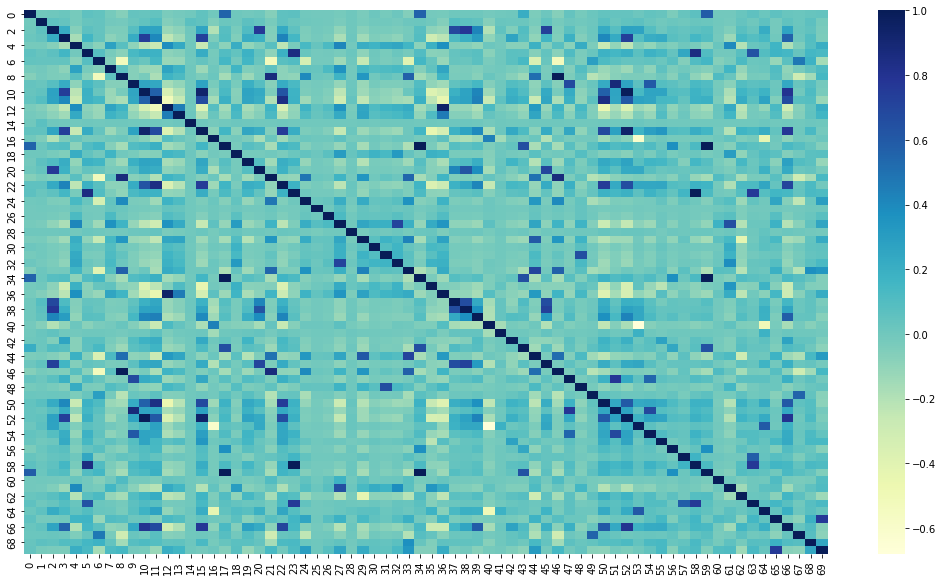

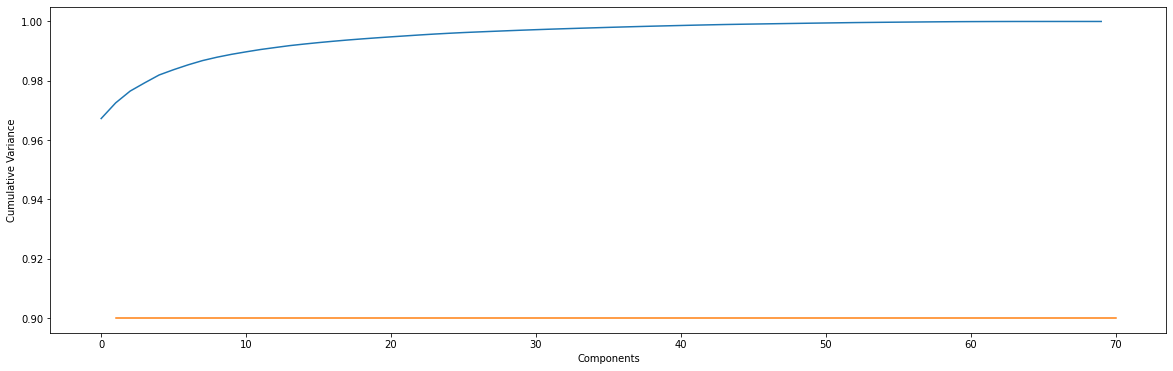

In [13]:
## PCA on Deliqunecy
# distributing the dataset into two components X and Y
x = agg_amex_data[Deliquency_variables].values
plt.figure(figsize = (18,10))        
sns.heatmap(pd.DataFrame(x).corr(),annot = False,cmap="YlGnBu")


# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=70)
pcs.fit(x)

## Cumulative Variance chart
Figure = plt.figure(figsize = (20,6))
plt.plot(np.cumsum(pcs.explained_variance_ratio_))
plt.plot(range(1, 71), [0.9] * 70, label = "threshold")
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')


pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 71)]
pcsSummary.round(4)

In [14]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Deliquency_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
deliquency_variables = pca_features[['Deliquency_{}'.format(i) for i in range(1, 39 )]]
deliquency_variables

,Deliquency_1,Deliquency_2,Deliquency_3,Deliquency_4,Deliquency_5,Deliquency_6,Deliquency_7,Deliquency_8,Deliquency_9,Deliquency_10,...,Deliquency_29,Deliquency_30,Deliquency_31,Deliquency_32,Deliquency_33,Deliquency_34,Deliquency_35,Deliquency_36,Deliquency_37,Deliquency_38
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.148517,-0.111649,-1.624415,-0.195931,-0.581472,0.114597,0.018388,-0.105460,-0.702790,0.026228,...,0.470533,-0.118641,-0.070516,0.247727,0.087886,-0.085382,-0.581232,-0.192491,0.107721,-0.045776
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.148475,-1.073413,0.072831,-0.081459,0.080704,-0.058788,0.110714,0.044548,0.119921,-0.030199,...,0.254894,-0.100230,0.076732,0.058280,-0.061744,-0.078304,0.348810,0.259622,0.012712,0.036482
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,-0.148535,-0.935740,0.666896,0.137002,-0.224969,-0.162695,0.221159,0.043641,0.261870,0.170135,...,0.020977,-0.017074,0.165706,0.132929,-0.017319,-0.056327,0.005910,0.016197,0.068469,-0.000912
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.149120,-0.893206,-0.298967,-0.286979,0.318684,0.151503,-0.731973,-0.102242,0.007313,0.067636,...,0.148459,-0.099633,0.006179,0.005828,-0.104844,-0.051105,0.345427,-0.077157,-0.125970,0.026906
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.149152,0.491890,-1.209553,0.283123,-0.124460,-0.231913,0.093522,0.405824,0.448782,0.042966,...,-0.003628,0.081216,0.020148,0.051991,0.113980,-0.088088,0.008444,-0.001169,0.006387,0.009711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.150208,-0.216107,-0.218984,0.041179,-1.414291,0.070504,0.113224,0.125034,-0.534977,-0.066117,...,-0.478187,0.275179,0.716419,-0.437006,0.142187,-0.137856,0.267646,-0.026590,0.139127,-0.018510
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,-0.148346,0.684758,-1.176019,0.493200,0.241128,-0.351758,0.299182,1.239787,0.049833,0.095023,...,0.156355,-0.083254,-0.186428,0.095788,0.446583,-0.005147,-0.106845,-0.003793,0.071328,0.032052
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.149149,-0.107577,-1.056243,-0.104410,-0.447445,0.217308,-0.282225,-0.167854,-0.197305,-0.170764,...,0.191313,-0.008701,0.041117,0.060288,-0.112764,0.044934,0.064526,-0.068570,-0.076200,0.015027


### **Spend**

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Standard deviation,0.7353,0.5984,0.4348,0.3975,0.3578,0.3397,0.2990,0.2615,0.1894,0.1593,0.1504,0.1343,0.1309,0.1257,0.1078,0.1003,0.0775,0.0599,0.0545,0.043
Proportion of variance,0.2974,0.1970,0.1040,0.0869,0.0704,0.0635,0.0492,0.0376,0.0197,0.0140,0.0124,0.0099,0.0094,0.0087,0.0064,0.0055,0.0033,0.0020,0.0016,0.001
Cumulative proportion,0.2974,0.4944,0.5984,0.6853,0.7557,0.8192,0.8683,0.9060,0.9257,0.9396,0.9521,0.9620,0.9714,0.9801,0.9865,0.9921,0.9954,0.9973,0.9990,1.000


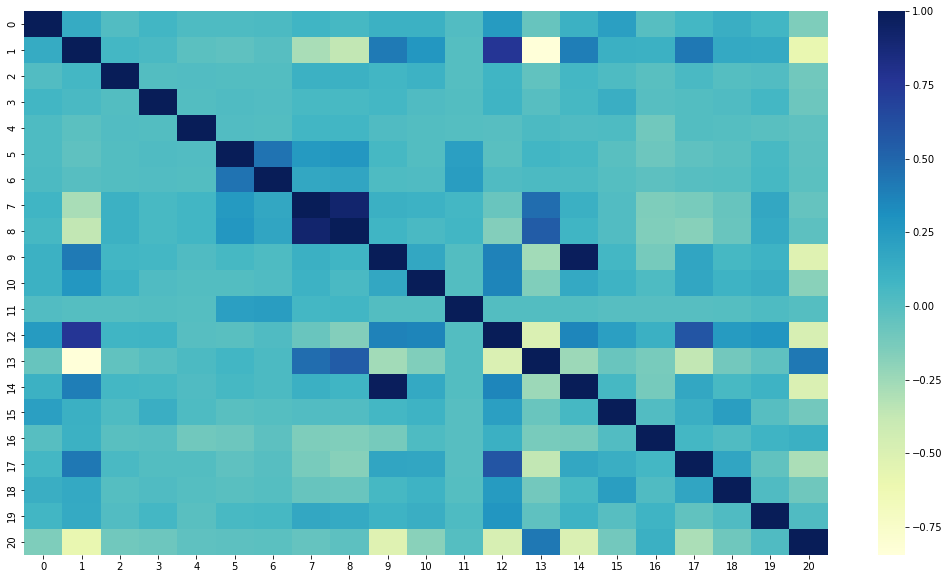

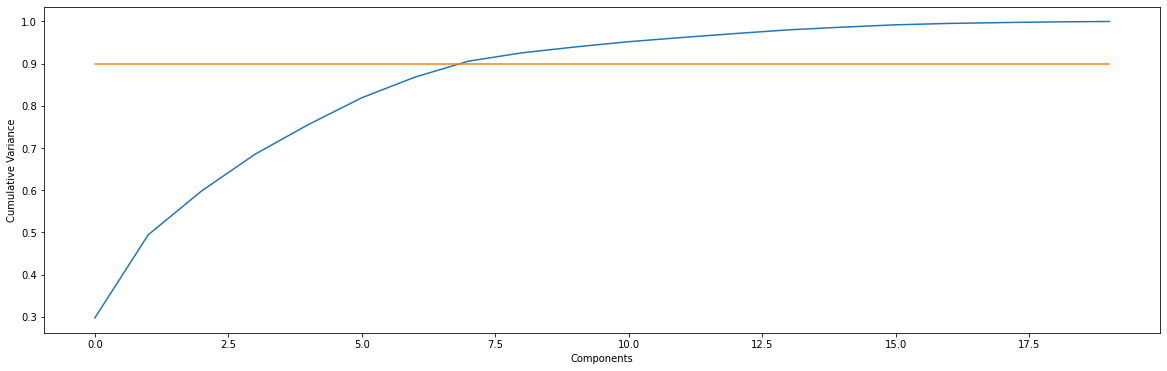

In [15]:
## PCA on Spend
# distributing the dataset into two components X and Y
x = agg_amex_data[Spend_variables].values
plt.figure(figsize = (18,10))        
sns.heatmap(pd.DataFrame(x).corr(),annot = False,cmap="YlGnBu")


# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=20)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

## Cumulative Variance chart
Figure = plt.figure(figsize = (20,6))
plt.plot(np.cumsum(pcs.explained_variance_ratio_))
plt.plot(list(range(0,20 )), [0.9] * 20, label = "threshold")
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')



pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 21)]
pcsSummary.round(4)

In [16]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Spend_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
spend_variables = pca_features[['Spend_{}'.format(i) for i in range(1, 9 )]]
spend_variables

,Spend_1,Spend_2,Spend_3,Spend_4,Spend_5,Spend_6,Spend_7,Spend_8
customer_ID,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.511767,-0.103292,0.228514,-0.143494,-0.490985,0.449631,-0.352761,-0.069682
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.257030,-0.101753,-0.073146,-0.068614,-0.109153,-0.262305,-0.060236,0.001760
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,1.117758,0.050266,-0.098941,-0.019426,0.283049,0.126437,-0.021596,-0.231990
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.358441,-0.067120,-0.035483,-0.060678,-0.090638,0.184293,-0.056373,0.185811
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.914036,0.027244,-0.101350,-0.027375,0.229011,0.076484,-0.034798,-0.197006
...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.434094,-0.102536,0.134412,-0.069228,-0.191004,0.042173,0.044287,-0.063074
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.426923,-0.014537,-0.184234,-0.006502,0.234127,-0.228777,0.096396,0.013600
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.448061,-0.117838,0.111095,-0.110395,-0.352408,0.000899,-0.175452,-0.132935


In [17]:
pca_features

,Spend_1,Spend_2,Spend_3,Spend_4,Spend_5,Spend_6,Spend_7,Spend_8,Spend_9,Spend_10,Spend_11,Spend_12,Spend_13,Spend_14,Spend_15,Spend_16,Spend_17,Spend_18,Spend_19,Spend_20
customer_ID,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.511767,-0.103292,0.228514,-0.143494,-0.490985,0.449631,-0.352761,-0.069682,0.057484,-0.032074,0.042735,0.001977,0.028624,0.006241,-0.021343,-0.055418,0.002881,0.005676,0.029230,0.001717
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.257030,-0.101753,-0.073146,-0.068614,-0.109153,-0.262305,-0.060236,0.001760,0.192599,0.012015,0.010416,0.039939,-0.065421,-0.000020,-0.062895,0.020557,0.000583,0.000542,-0.007267,-0.000319
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,1.117758,0.050266,-0.098941,-0.019426,0.283049,0.126437,-0.021596,-0.231990,-0.029310,0.003090,0.004235,-0.004781,-0.012175,-0.001774,0.005397,-0.006345,-0.000132,-0.017358,-0.006583,-0.006765
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.358441,-0.067120,-0.035483,-0.060678,-0.090638,0.184293,-0.056373,0.185811,0.031451,-0.055266,0.055464,0.014627,-0.085690,-0.017589,0.181900,0.001246,-0.006084,0.005771,-0.044839,0.017320
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.914036,0.027244,-0.101350,-0.027375,0.229011,0.076484,-0.034798,-0.197006,0.029529,0.006184,0.003795,-0.016418,-0.039517,-0.003894,-0.008424,0.009610,-0.002864,-0.011115,0.013190,0.015099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.434094,-0.102536,0.134412,-0.069228,-0.191004,0.042173,0.044287,-0.063074,0.132767,0.021854,0.025261,0.070541,-0.001416,-0.006666,0.220208,0.001225,-0.018332,0.002016,0.003906,0.029071
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.426923,-0.014537,-0.184234,-0.006502,0.234127,-0.228777,0.096396,0.013600,0.003770,-0.023898,-0.028486,0.036842,-0.079850,-0.140809,-0.019359,0.008942,0.002338,-0.008335,-0.003373,0.034900
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.448061,-0.117838,0.111095,-0.110395,-0.352408,0.000899,-0.175452,-0.132935,0.081467,-0.011683,0.045529,0.019456,-0.001097,0.017861,-0.060804,-0.004890,0.002320,-0.003312,0.036762,-0.010044


### **Payment**

,PC1,PC2,PC3
Standard deviation,0.3652,0.2177,0.1070
Proportion of variance,0.6939,0.2465,0.0595
Cumulative proportion,0.6939,0.9405,1.0000


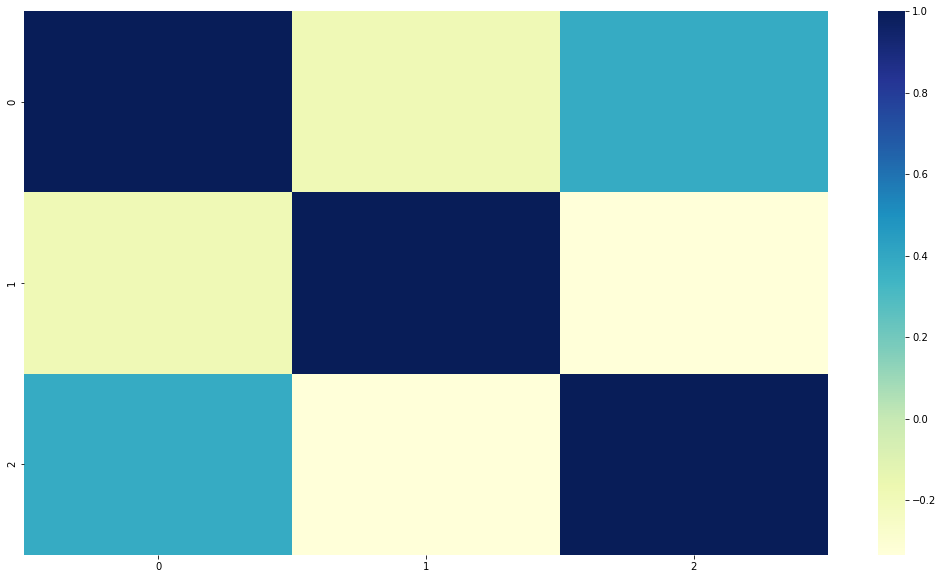

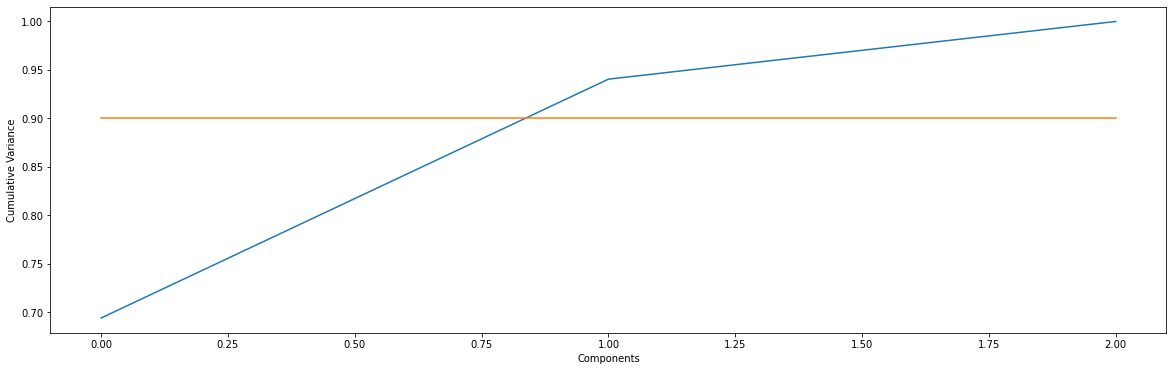

In [18]:
## PCA on Payment
# distributing the dataset into two components X and Y
x = agg_amex_data[Payment_variables].values
plt.figure(figsize = (18,10))        
sns.heatmap(pd.DataFrame(x).corr(),annot = False,cmap="YlGnBu")


# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=3)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

## Cumulative Variance chart
Figure = plt.figure(figsize = (20,6))
plt.plot(np.cumsum(pcs.explained_variance_ratio_))
plt.plot(list(range(0,3 )), [0.9] * 3, label = "threshold")
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')



pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 4)]
pcsSummary.round(4)

In [19]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Payment_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
payment_variables = pca_features[['Payment_{}'.format(i) for i in range(1, 4 )]]
payment_variables

,Payment_1,Payment_2,Payment_3
customer_ID,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.276356,-0.212009,0.012997
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.254816,-0.157165,-0.089453
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,-0.251325,-0.148783,-0.034605
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.155757,0.107431,0.022695
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.249743,-0.140689,-0.126034
...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.249601,-0.137716,0.048266
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,-0.246245,-0.128117,-0.041163
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.222397,-0.067959,0.001289


### **Balance**

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Standard deviation,5.5783,2.1580,1.5118,1.0370,0.9317,0.9173,0.6175,0.4830,0.2989,0.2878,0.2658,0.2459,0.2292,0.1978,0.1826,0.1716,0.1620,0.1450,0.1323,0.1310
Proportion of variance,0.7398,0.1107,0.0543,0.0256,0.0206,0.0200,0.0091,0.0055,0.0021,0.0020,0.0017,0.0014,0.0012,0.0009,0.0008,0.0007,0.0006,0.0005,0.0004,0.0004
Cumulative proportion,0.7398,0.8505,0.9049,0.9304,0.9511,0.9711,0.9801,0.9857,0.9878,0.9898,0.9915,0.9929,0.9941,0.9951,0.9959,0.9966,0.9972,0.9977,0.9981,0.9985


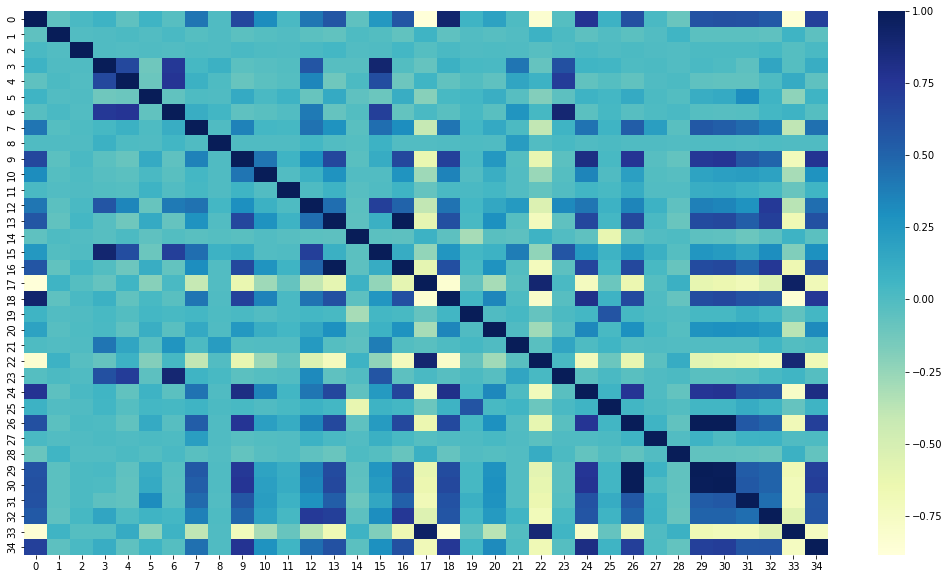

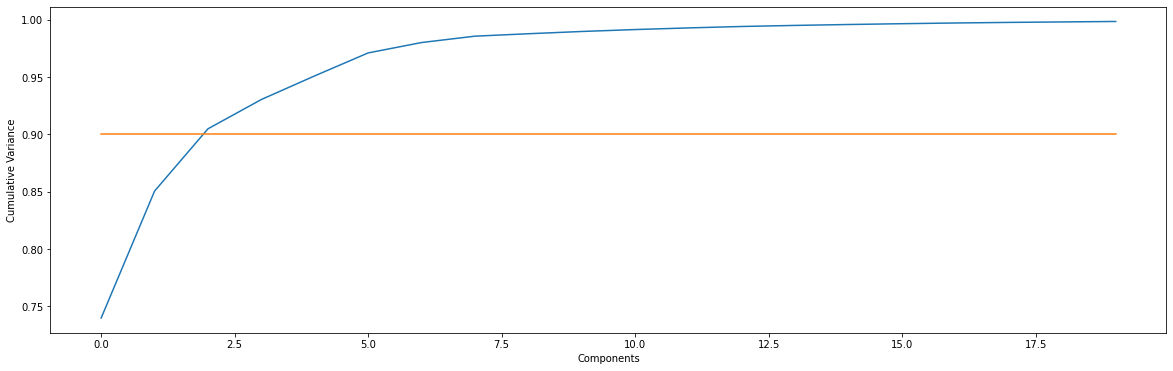

In [20]:
## PCA on Balance
# distributing the dataset into two components X and Y
x = agg_amex_data[Balance_variables].values
plt.figure(figsize = (18,10))        
sns.heatmap(pd.DataFrame(x).corr(),annot = False,cmap="YlGnBu")


# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=20)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

## Cumulative Variance chart
Figure = plt.figure(figsize = (20,6))
plt.plot(np.cumsum(pcs.explained_variance_ratio_))
plt.plot(list(range(0,20 )), [0.9] * 20, label = "threshold")
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')



pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pcsSummary.round(4)

In [21]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Balance_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
balance_variables = pca_features[['Balance_{}'.format(i) for i in range(1, 4 )]]
balance_variables

,Balance_1,Balance_2,Balance_3
customer_ID,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.118724,0.068751,-0.091721
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.184157,0.100758,-0.125155
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,-0.178493,0.071492,-0.132980
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.131971,0.103686,-0.123213
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.055377,-0.113172,-0.124532
...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.189147,0.397184,-0.065019
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.049506,-0.255494,-0.086906
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.182785,0.061173,-0.115939


### **Risk**

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
Standard deviation,5.3227,0.7870,0.3633,0.3000,0.2317,0.2060,0.1782,0.1443,0.1256,0.1158,0.1107,0.0947,0.0702,0.0652,0.0550,0.0488,0.0387,0.0301,0.0273,0.0265
Proportion of variance,0.9639,0.0211,0.0045,0.0031,0.0018,0.0014,0.0011,0.0007,0.0005,0.0005,0.0004,0.0003,0.0002,0.0001,0.0001,0.0001,0.0001,0.0000,0.0000,0.0000
Cumulative proportion,0.9639,0.9850,0.9895,0.9926,0.9944,0.9958,0.9969,0.9976,0.9982,0.9986,0.9990,0.9993,0.9995,0.9997,0.9998,0.9998,0.9999,0.9999,0.9999,1.0000


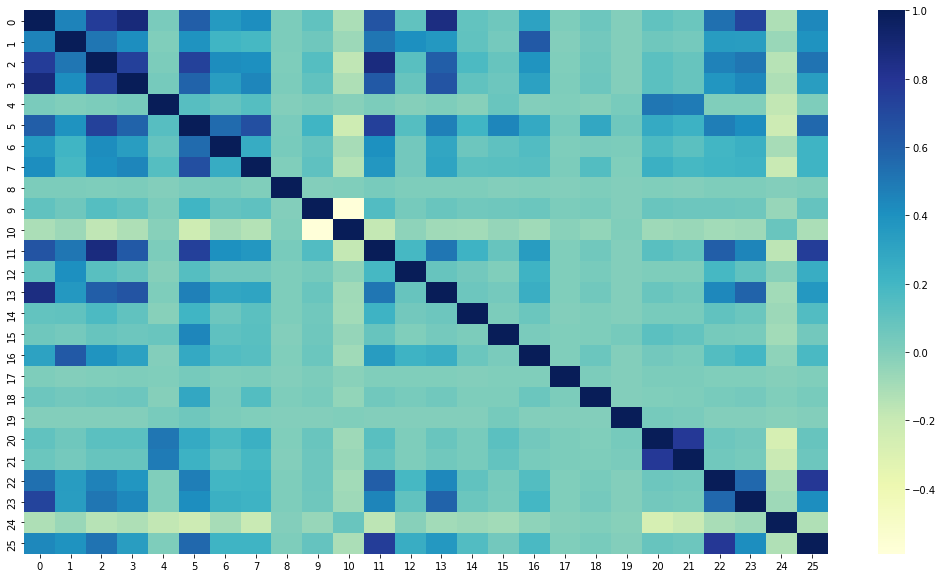

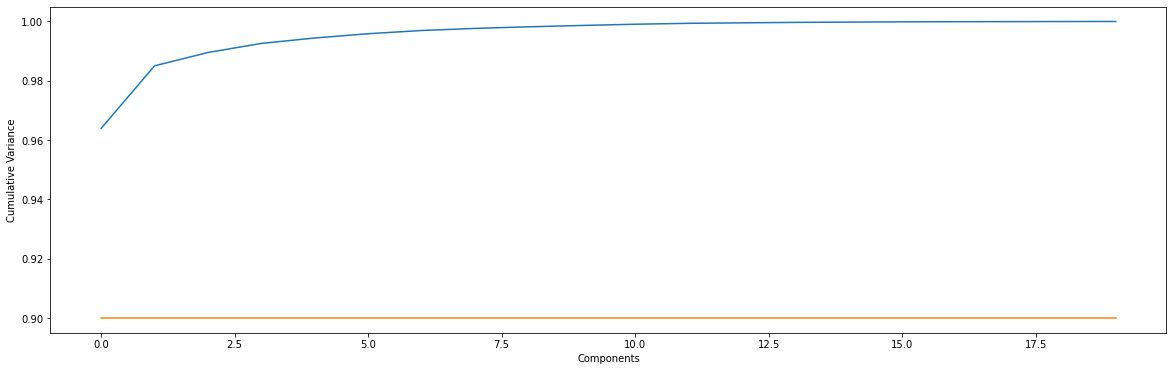

In [22]:
## PCA on Risk
# distributing the dataset into two components X and Y
x = agg_amex_data[Risk_variables].values
plt.figure(figsize = (18,10))        
sns.heatmap(pd.DataFrame(x).corr(),annot = False,cmap="YlGnBu")


# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=20)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

## Cumulative Variance chart
Figure = plt.figure(figsize = (20,6))
plt.plot(np.cumsum(pcs.explained_variance_ratio_))
plt.plot(list(range(0,20 )), [0.9] * 20, label = "threshold")
plt.xlabel('Components')
plt.ylabel('Cumulative Variance')



pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 21)]
pcsSummary.round(4)

In [23]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Risk_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
risk_variables = pca_features[['Risk_{}'.format(i) for i in range(1, 15 )]]
risk_variables

,Risk_1,Risk_2,Risk_3,Risk_4,Risk_5,Risk_6,Risk_7,Risk_8,Risk_9,Risk_10,Risk_11,Risk_12,Risk_13,Risk_14
customer_ID,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.236144,-0.108846,0.163702,-0.082460,-0.043460,-0.091402,0.017073,0.012138,0.012285,0.009724,-0.003114,0.005272,-0.006831,0.020375
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.236352,-0.107945,0.148609,-0.064786,-0.029620,-0.031253,-0.010006,0.023691,0.013139,0.009095,0.000519,0.006359,0.016836,0.011605
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,-0.236995,-0.109183,0.164030,-0.080833,-0.043037,-0.091185,0.018408,0.011931,0.013295,0.008959,-0.002987,0.005217,-0.007366,0.019433
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.236243,-0.108888,0.143042,-0.058212,-0.024433,-0.011466,-0.021872,0.026169,0.013008,0.009056,0.002338,0.004432,0.028589,0.040319
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.236759,-0.109254,0.160402,-0.075753,-0.038479,-0.073548,0.008254,0.016486,0.013807,0.009904,-0.001349,0.009177,0.017819,-0.005192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.236821,-0.105516,0.121985,-0.036423,-0.008336,0.065378,-0.059266,0.041919,0.013262,0.007844,0.006590,0.005844,0.015321,-0.010920
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,-0.236790,-0.109513,0.155289,-0.073449,-0.034794,-0.057284,0.000585,0.017546,0.014581,0.008450,-0.000589,0.009054,0.033410,0.024800
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.237483,-0.107650,0.139968,-0.055913,-0.021873,0.000858,-0.027347,0.028992,0.013098,0.009314,0.002876,0.005778,0.020305,0.036065


In [24]:
pca_features

,Risk_1,Risk_2,Risk_3,Risk_4,Risk_5,Risk_6,Risk_7,Risk_8,Risk_9,Risk_10,Risk_11,Risk_12,Risk_13,Risk_14,Risk_15,Risk_16,Risk_17,Risk_18,Risk_19,Risk_20
customer_ID,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.236144,-0.108846,0.163702,-0.082460,-0.043460,-0.091402,0.017073,0.012138,0.012285,0.009724,-0.003114,0.005272,-0.006831,0.020375,-0.001284,0.001033,-0.000343,-0.000167,-0.002482,-0.001451
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.236352,-0.107945,0.148609,-0.064786,-0.029620,-0.031253,-0.010006,0.023691,0.013139,0.009095,0.000519,0.006359,0.016836,0.011605,-0.002742,0.002336,0.000899,0.001953,-0.002153,0.001011
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,-0.236995,-0.109183,0.164030,-0.080833,-0.043037,-0.091185,0.018408,0.011931,0.013295,0.008959,-0.002987,0.005217,-0.007366,0.019433,0.000021,0.001524,0.001093,-0.000083,-0.001290,-0.000285
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.236243,-0.108888,0.143042,-0.058212,-0.024433,-0.011466,-0.021872,0.026169,0.013008,0.009056,0.002338,0.004432,0.028589,0.040319,-0.002006,0.003817,-0.000478,0.001975,-0.001352,0.000692
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.236759,-0.109254,0.160402,-0.075753,-0.038479,-0.073548,0.008254,0.016486,0.013807,0.009904,-0.001349,0.009177,0.017819,-0.005192,-0.004207,0.003007,-0.000100,-0.000493,-0.001666,-0.001573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.236821,-0.105516,0.121985,-0.036423,-0.008336,0.065378,-0.059266,0.041919,0.013262,0.007844,0.006590,0.005844,0.015321,-0.010920,-0.010052,0.007086,-0.000728,0.001510,-0.001871,-0.000350
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,-0.236790,-0.109513,0.155289,-0.073449,-0.034794,-0.057284,0.000585,0.017546,0.014581,0.008450,-0.000589,0.009054,0.033410,0.024800,-0.004093,0.002938,-0.000987,-0.000439,-0.002988,0.000613
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.237483,-0.107650,0.139968,-0.055913,-0.021873,0.000858,-0.027347,0.028992,0.013098,0.009314,0.002876,0.005778,0.020305,0.036065,-0.004357,0.003818,-0.000055,0.001532,-0.002666,-0.000163


### Final Data after dimensionality reduction

In [25]:
amex_data_red = pd.concat([deliquency_variables, spend_variables, payment_variables, balance_variables, risk_variables], axis = 1)
amex_data_processed = amex_data_red.join(amex_labels)
amex_data_processed

,Deliquency_1,Deliquency_2,Deliquency_3,Deliquency_4,Deliquency_5,Deliquency_6,Deliquency_7,Deliquency_8,Deliquency_9,Deliquency_10,...,Risk_6,Risk_7,Risk_8,Risk_9,Risk_10,Risk_11,Risk_12,Risk_13,Risk_14,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.148517,-0.111649,-1.624415,-0.195931,-0.581472,0.114597,0.018388,-0.105460,-0.702790,0.026228,...,-0.091402,0.017073,0.012138,0.012285,0.009724,-0.003114,0.005272,-0.006831,0.020375,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.148475,-1.073413,0.072831,-0.081459,0.080704,-0.058788,0.110714,0.044548,0.119921,-0.030199,...,-0.031253,-0.010006,0.023691,0.013139,0.009095,0.000519,0.006359,0.016836,0.011605,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,-0.148535,-0.935740,0.666896,0.137002,-0.224969,-0.162695,0.221159,0.043641,0.261870,0.170135,...,-0.091185,0.018408,0.011931,0.013295,0.008959,-0.002987,0.005217,-0.007366,0.019433,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.149120,-0.893206,-0.298967,-0.286979,0.318684,0.151503,-0.731973,-0.102242,0.007313,0.067636,...,-0.011466,-0.021872,0.026169,0.013008,0.009056,0.002338,0.004432,0.028589,0.040319,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.149152,0.491890,-1.209553,0.283123,-0.124460,-0.231913,0.093522,0.405824,0.448782,0.042966,...,-0.073548,0.008254,0.016486,0.013807,0.009904,-0.001349,0.009177,0.017819,-0.005192,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,-0.150208,-0.216107,-0.218984,0.041179,-1.414291,0.070504,0.113224,0.125034,-0.534977,-0.066117,...,0.065378,-0.059266,0.041919,0.013262,0.007844,0.006590,0.005844,0.015321,-0.010920,0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,-0.148346,0.684758,-1.176019,0.493200,0.241128,-0.351758,0.299182,1.239787,0.049833,0.095023,...,-0.057284,0.000585,0.017546,0.014581,0.008450,-0.000589,0.009054,0.033410,0.024800,0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,-0.149149,-0.107577,-1.056243,-0.104410,-0.447445,0.217308,-0.282225,-0.167854,-0.197305,-0.170764,...,0.000858,-0.027347,0.028992,0.013098,0.009314,0.002876,0.005778,0.020305,0.036065,0


In [26]:
amex_data_processed.to_csv('processed_data.csv',index=False)

<a id="5"></a>
# <div style='display:fill;color:#dfe3e8;background-color:#053673;padding:20px'>   <b> Feature Selection</b> </div>

In [27]:
amex_data_processed.head()

,Deliquency_1,Deliquency_2,Deliquency_3,Deliquency_4,Deliquency_5,Deliquency_6,Deliquency_7,Deliquency_8,Deliquency_9,Deliquency_10,...,Risk_6,Risk_7,Risk_8,Risk_9,Risk_10,Risk_11,Risk_12,Risk_13,Risk_14,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,-0.148517,-0.111649,-1.624415,-0.195931,-0.581472,0.114597,0.018388,-0.105460,-0.702790,0.026228,...,-0.091402,0.017073,0.012138,0.012285,0.009724,-0.003114,0.005272,-0.006831,0.020375,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,-0.148475,-1.073413,0.072831,-0.081459,0.080704,-0.058788,0.110714,0.044548,0.119921,-0.030199,...,-0.031253,-0.010006,0.023691,0.013139,0.009095,0.000519,0.006359,0.016836,0.011605,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,-0.148535,-0.935740,0.666896,0.137002,-0.224969,-0.162695,0.221159,0.043641,0.261870,0.170135,...,-0.091185,0.018408,0.011931,0.013295,0.008959,-0.002987,0.005217,-0.007366,0.019433,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,-0.149120,-0.893206,-0.298967,-0.286979,0.318684,0.151503,-0.731973,-0.102242,0.007313,0.067636,...,-0.011466,-0.021872,0.026169,0.013008,0.009056,0.002338,0.004432,0.028589,0.040319,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,-0.149152,0.491890,-1.209553,0.283123,-0.124460,-0.231913,0.093522,0.405824,0.448782,0.042966,...,-0.073548,0.008254,0.016486,0.013807,0.009904,-0.001349,0.009177,0.017819,-0.005192,0


In [28]:
from sklearn.feature_selection import SelectKBest, chi2

X = amex_data_processed.drop(["target"], axis = 1)
y = amex_data_processed["target"]

feature_selector = SelectKBest(chi2, k = "all")
fit = feature_selector.fit(X,y)

p_values = pd.DataFrame(fit.pvalues_)
scores = pd.DataFrame(fit.scores_)
input_variable_names = pd.DataFrame(X.columns)
summary_stats = pd.concat([input_variable_names, p_values, scores], axis = 1)
summary_stats.columns = ["input_variable", "p_value", "chi2_score"]
summary_stats.sort_values(by = "p_value", inplace = True)

p_value_threshold = 0.05
score_threshold = 5

selected_variables = summary_stats.loc[(summary_stats["chi2_score"] >= score_threshold) &
                                       (summary_stats["p_value"] <= p_value_threshold)]
selected_variables = selected_variables["input_variable"].tolist()
X_new = X[selected_variables]

ValueError: Input X must be non-negative.

<a id="5"></a>
# <div style='display:fill;color:#dfe3e8;background-color:#053673;padding:20px'>   <b> Model Building </b> </div>

# Split Data into Train & Test

In [ ]:
x = amex_data_processed.loc[:, amex_data_processed.columns != 'target']
y = amex_data_processed['target']
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y,test_size=0.15, random_state=10)

print('Train Data size: ',len(x_train))
print('Test Data size: ',len(x_test))

In [ ]:
#sns.countplot(data = y_train)
temp1 = pd.DataFrame(y_train,columns=['target'])
temp2 = pd.DataFrame(y_test,columns=['target'])


## Plot the charts
fig,plts = plt.subplots(1,2, figsize=(20,6))
#fig, (plt1,plt2,plt3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribution of target variable', size=15)
sns.countplot(x='target',data=temp1, ax=plts[0])
plts[0].set(xlabel='Target', ylabel='No. of Customers', title='Train Data')
abs_values = temp1['target'].value_counts(ascending=False)
rel_values = temp1['target'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
plts[0].bar_label(container=plts[0].containers[0], labels=lbls)





sns.countplot(x='target',data=temp2, ax=plts[1])
plts[1].set(xlabel='Target', ylabel='No. of Customers', title='Test Data')
abs_values = temp2['target'].value_counts(ascending=False)
rel_values = temp2['target'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]
plts[1].bar_label(container=plts[1].containers[0], labels=lbls)

# Decision Tree

In [ ]:
# ## Model initialization
# mtype = 'Decision Tree'
# cutoffs = [0.3,0.4,0.5,0.6,0.7]
# cutoff = []
# train_acc = []
# test_acc= []
# roc_auc = []
# precision = []
# recall= []
# f1 = []

# ## Define Classifier
# clf = DecisionTreeClassifier(random_state=10)
# model = clf.fit(x_train, y_train)


# ## Make Predictions
# y_pred_prob = model.predict_proba(x_test)[:,1]
# y_pred_prob_train = model.predict_proba(x_train)[:,1]
# fig1, ax = plt.subplots(1, 5, figsize=(20, 3),constrained_layout = True)


# ## Performance of the model
# for i in range(0, len(cutoffs)):
#     y_pred = (y_pred_prob>=cutoffs[i])*1
#     y_pred_train = (y_pred_prob_train>=cutoffs[i])*1

#     #  Performance Report
#     cutoff.append(cutoffs[i])
#     train_acc.append(round(sum((y_pred_train==y_train)*1)/len(y_pred_train),4))
#     test_acc.append(round(sum((y_pred==y_test)*1)/len(y_pred),4))
#     roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
     
    
#     #  Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
#     ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_ ).plot(ax=ax[i],cmap="YlGnBu")
#     ax[i].set(title='Confusion matrix at cutoff: '+ str(cutoffs[i]))
      
#    #   Classification Report
#     prfs = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
#     precision.append(round(prfs[0],4))
#     recall.append(round(prfs[1],4))
#     f1.append(round(prfs[2],4))

# perf = pd.DataFrame(list(zip(cutoff, train_acc, test_acc, roc_auc)), columns =['Prob Cutoff', 'Training Accuracy', 'Test Accuracy', 'ROC AUC Score'])
# prfs = pd.DataFrame(list(zip(cutoff, precision, recall, f1)), columns =['Prob Cutoff', 'Precision', 'Recall', 'F1 Score'])


# print("-"*15,"PERFORMANCE REPORT","-"*15)
# print(perf)
# print("-"*15,"CLASSIFICATION REPORT","-"*15)
# print(prfs)

# # precision-recall curve
# fig2, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6),constrained_layout = True)
    
# precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
# avg_pre = average_precision_score(y_test, y_pred_prob)
# ax1.plot(precision, recall, label = mtype+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
# ax1.set_xlabel('Precision', fontsize = 14)
# ax1.set_ylabel('Recall', fontsize = 14)
# ax1.set_title('Precision-Recall Curve', fontsize = 18)
# ax1.legend(loc = 'best')
# #find default threshold
# close_default = np.argmin(np.abs(thresholds_pr - 0.5))
# ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

# # roc-curve
# fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr,tpr)
# ax2.plot(fpr,tpr, label = mtype+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
# ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
# ax2.set_xlabel("False Positive Rate", fontsize = 14)
# ax2.set_ylabel("True Positive Rate", fontsize = 14)
# ax2.set_title("ROC Curve", fontsize = 18)
# ax2.legend(loc = 'best')


# # find default threshold
# close_default = np.argmin(np.abs(thresholds_roc - 0.5))
# ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
# plt.tight_layout()

# Random Forest

In [ ]:
# ## Model initialization
# mtype = 'Random Forest'
# cutoffs = [0.3,0.4,0.5,0.6,0.7]
# cutoff = []
# train_acc = []
# test_acc= []
# roc_auc = []
# precision = []
# recall= []
# f1 = []

# ## Define Classifier
# clf = RandomForestClassifier(random_state=10)
# model = clf.fit(x_train, y_train)


# ## Make Predictions
# y_pred_prob = model.predict_proba(x_test)[:,1]
# y_pred_prob_train = model.predict_proba(x_train)[:,1]
# fig1, ax = plt.subplots(1, 5, figsize=(20, 3),constrained_layout = True)


# ## Performance of the model
# for i in range(0, len(cutoffs)):
#     y_pred = (y_pred_prob>=cutoffs[i])*1
#     y_pred_train = (y_pred_prob_train>=cutoffs[i])*1

#     #  Performance Report
#     cutoff.append(cutoffs[i])
#     train_acc.append(round(sum((y_pred_train==y_train)*1)/len(y_pred_train),4))
#     test_acc.append(round(sum((y_pred==y_test)*1)/len(y_pred),4))
#     roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
     
    
#     #  Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
#     ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_ ).plot(ax=ax[i],cmap="YlGnBu")
#     ax[i].set(title='Confusion matrix at cutoff: '+ str(cutoffs[i]))
      
#    #   Classification Report
#     prfs = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
#     precision.append(round(prfs[0],4))
#     recall.append(round(prfs[1],4))
#     f1.append(round(prfs[2],4))

# perf = pd.DataFrame(list(zip(cutoff, train_acc, test_acc, roc_auc)), columns =['Prob Cutoff', 'Training Accuracy', 'Test Accuracy', 'ROC AUC Score'])
# prfs = pd.DataFrame(list(zip(cutoff, precision, recall, f1)), columns =['Prob Cutoff', 'Precision', 'Recall', 'F1 Score'])


# print("-"*15,"PERFORMANCE REPORT","-"*15)
# print(perf)
# print("-"*15,"CLASSIFICATION REPORT","-"*15)
# print(prfs)

# # precision-recall curve
# fig2, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6),constrained_layout = True)
    
# precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
# avg_pre = average_precision_score(y_test, y_pred_prob)
# ax1.plot(precision, recall, label = mtype+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
# ax1.set_xlabel('Precision', fontsize = 14)
# ax1.set_ylabel('Recall', fontsize = 14)
# ax1.set_title('Precision-Recall Curve', fontsize = 18)
# ax1.legend(loc = 'best')
# #find default threshold
# close_default = np.argmin(np.abs(thresholds_pr - 0.5))
# ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

# # roc-curve
# fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
# roc_auc = auc(fpr,tpr)
# ax2.plot(fpr,tpr, label = mtype+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
# ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
# ax2.set_xlabel("False Positive Rate", fontsize = 14)
# ax2.set_ylabel("True Positive Rate", fontsize = 14)
# ax2.set_title("ROC Curve", fontsize = 18)
# ax2.legend(loc = 'best')


# # find default threshold
# close_default = np.argmin(np.abs(thresholds_roc - 0.5))
# ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
# plt.tight_layout()

In [ ]:
# save the model
import joblib

# save
joblib.dump(model, "random_forest.joblib")

# **BalancedBaggingClassifier**

In [ ]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
#Create an instance
classifier = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='not majority',
                                replacement=False,
                                random_state=42)
classifier.fit(x_train, y_train)
preds = classifier.predict(x_test)

In [ ]:
## Model initialization
mtype = 'BalancedBaggingClassifier'
cutoffs = [0.3,0.4,0.5,0.6,0.7]
cutoff = []
train_acc = []
test_acc= []
roc_auc = []
precision = []
recall= []
f1 = []

y_pred_prob = classifier.predict_proba(x_test)[:,1]
y_pred_prob_train = classifier.predict_proba(x_train)[:,1]
fig1, ax = plt.subplots(1, 5, figsize=(20, 3),constrained_layout = True)

## Performance of the model
for i in range(0, len(cutoffs)):
    y_pred = (y_pred_prob>=cutoffs[i])*1
    y_pred_train = (y_pred_prob_train>=cutoffs[i])*1

    #  Performance Report
    cutoff.append(cutoffs[i])
    train_acc.append(round(sum((y_pred_train==y_train)*1)/len(y_pred_train),4))
    test_acc.append(round(sum((y_pred==y_test)*1)/len(y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
     
    
    #  Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_ ).plot(ax=ax[i],cmap="YlGnBu")
    ax[i].set(title='Confusion matrix at cutoff: '+ str(cutoffs[i]))
      
   #   Classification Report
    prfs = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
    precision.append(round(prfs[0],4))
    recall.append(round(prfs[1],4))
    f1.append(round(prfs[2],4))

perf = pd.DataFrame(list(zip(cutoff, train_acc, test_acc, roc_auc)), columns =['Prob Cutoff', 'Training Accuracy', 'Test Accuracy', 'ROC AUC Score'])
prfs = pd.DataFrame(list(zip(cutoff, precision, recall, f1)), columns =['Prob Cutoff', 'Precision', 'Recall', 'F1 Score'])


print("-"*15,"PERFORMANCE REPORT","-"*15)
print(perf)
print("-"*15,"CLASSIFICATION REPORT","-"*15)
print(prfs)

# precision-recall curve
fig2, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6),constrained_layout = True)
    
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
avg_pre = average_precision_score(y_test, y_pred_prob)
ax1.plot(precision, recall, label = mtype+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
ax1.set_xlabel('Precision', fontsize = 14)
ax1.set_ylabel('Recall', fontsize = 14)
ax1.set_title('Precision-Recall Curve', fontsize = 18)
ax1.legend(loc = 'best')
#find default threshold
close_default = np.argmin(np.abs(thresholds_pr - 0.5))
ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

# roc-curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)
ax2.plot(fpr,tpr, label = mtype+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax2.set_xlabel("False Positive Rate", fontsize = 14)
ax2.set_ylabel("True Positive Rate", fontsize = 14)
ax2.set_title("ROC Curve", fontsize = 18)
ax2.legend(loc = 'best')


# find default threshold
close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()

# KNN

In [ ]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=5)

#Train the model using the training sets
knn.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
y_pred

In [ ]:
## Model initialization
mtype = 'knn'
cutoffs = [0.3,0.4,0.5,0.6,0.7]
cutoff = []
train_acc = []
test_acc= []
roc_auc = []
precision = []
recall= []
f1 = []

y_pred_prob = knn.predict_proba(x_test)[:,1]
y_pred_prob_train = knn.predict_proba(x_train)[:,1]
fig1, ax = plt.subplots(1, 5, figsize=(20, 3),constrained_layout = True)

## Performance of the model
for i in range(0, len(cutoffs)):
    y_pred = (y_pred_prob>=cutoffs[i])*1
    y_pred_train = (y_pred_prob_train>=cutoffs[i])*1

    #  Performance Report
    cutoff.append(cutoffs[i])
    train_acc.append(round(sum((y_pred_train==y_train)*1)/len(y_pred_train),4))
    test_acc.append(round(sum((y_pred==y_test)*1)/len(y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
     
    
    #  Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classifier.classes_ ).plot(ax=ax[i],cmap="YlGnBu")
    ax[i].set(title='Confusion matrix at cutoff: '+ str(cutoffs[i]))
      
   #   Classification Report
    prfs = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
    precision.append(round(prfs[0],4))
    recall.append(round(prfs[1],4))
    f1.append(round(prfs[2],4))

perf = pd.DataFrame(list(zip(cutoff, train_acc, test_acc, roc_auc)), columns =['Prob Cutoff', 'Training Accuracy', 'Test Accuracy', 'ROC AUC Score'])
prfs = pd.DataFrame(list(zip(cutoff, precision, recall, f1)), columns =['Prob Cutoff', 'Precision', 'Recall', 'F1 Score'])


print("-"*15,"PERFORMANCE REPORT","-"*15)
print(perf)
print("-"*15,"CLASSIFICATION REPORT","-"*15)
print(prfs)

# precision-recall curve
fig2, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6),constrained_layout = True)
    
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
avg_pre = average_precision_score(y_test, y_pred_prob)
ax1.plot(precision, recall, label = mtype+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
ax1.set_xlabel('Precision', fontsize = 14)
ax1.set_ylabel('Recall', fontsize = 14)
ax1.set_title('Precision-Recall Curve', fontsize = 18)
ax1.legend(loc = 'best')
#find default threshold
close_default = np.argmin(np.abs(thresholds_pr - 0.5))
ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

# roc-curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)
ax2.plot(fpr,tpr, label = mtype+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax2.set_xlabel("False Positive Rate", fontsize = 14)
ax2.set_ylabel("True Positive Rate", fontsize = 14)
ax2.set_title("ROC Curve", fontsize = 18)
ax2.legend(loc = 'best')


# find default threshold
close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()

In [ ]:
# save the model
import joblib

# save
joblib.dump(knn, "knn.joblib")

# SVC

In [ ]:
from sklearn.linear_model import SGDClassifier
 
# Instantiate SVM classifier using SGDClassifier
svm = SGDClassifier(loss='hinge')
 
# Fit the model
svm.fit(x_train, y_train)
 
# Model Performance
y_pred = svm.predict(x_test)
print('Accuracy: %.3f' % metrice.accuracy_score(y_test, y_pred))

# Gradient Boosting

In [ ]:
## Model initialization
mtype = 'Gradient Boosting'
cutoffs = [0.3,0.4,0.5,0.6,0.7]
cutoff = []
train_acc = []
test_acc= []
roc_auc = []
precision = []
recall= []
f1 = []

## Define Classifier
clf = GradientBoostingClassifier(random_state=10)
model = clf.fit(x_train, y_train)


## Make Predictions
y_pred_prob = model.predict_proba(x_test)[:,1]
y_pred_prob_train = model.predict_proba(x_train)[:,1]
fig1, ax = plt.subplots(1, 5, figsize=(20, 3),constrained_layout = True)


## Performance of the model
for i in range(0, len(cutoffs)):
    y_pred = (y_pred_prob>=cutoffs[i])*1
    y_pred_train = (y_pred_prob_train>=cutoffs[i])*1

    #  Performance Report
    cutoff.append(cutoffs[i])
    train_acc.append(round(sum((y_pred_train==y_train)*1)/len(y_pred_train),4))
    test_acc.append(round(sum((y_pred==y_test)*1)/len(y_pred),4))
    roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
     
    
    #  Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=clf.classes_ ).plot(ax=ax[i],cmap="YlGnBu")
    ax[i].set(title='Confusion matrix at cutoff: '+ str(cutoffs[i]))
      
   #   Classification Report
    prfs = precision_recall_fscore_support(y_test, y_pred, average='binary',pos_label=1)
    precision.append(round(prfs[0],4))
    recall.append(round(prfs[1],4))
    f1.append(round(prfs[2],4))

perf = pd.DataFrame(list(zip(cutoff, train_acc, test_acc, roc_auc)), columns =['Prob Cutoff', 'Training Accuracy', 'Test Accuracy', 'ROC AUC Score'])
prfs = pd.DataFrame(list(zip(cutoff, precision, recall, f1)), columns =['Prob Cutoff', 'Precision', 'Recall', 'F1 Score'])


print("-"*15,"PERFORMANCE REPORT","-"*15)
print(perf)
print("-"*15,"CLASSIFICATION REPORT","-"*15)
print(prfs)

# precision-recall curve
fig2, (ax1, ax2) = plt.subplots(1,2,figsize = (12,6),constrained_layout = True)
    
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_prob)
avg_pre = average_precision_score(y_test, y_pred_prob)
ax1.plot(precision, recall, label = mtype+ " average precision = {:0.2f}".format(avg_pre), lw = 3, alpha = 0.7)
ax1.set_xlabel('Precision', fontsize = 14)
ax1.set_ylabel('Recall', fontsize = 14)
ax1.set_title('Precision-Recall Curve', fontsize = 18)
ax1.legend(loc = 'best')
#find default threshold
close_default = np.argmin(np.abs(thresholds_pr - 0.5))
ax1.plot(precision[close_default], recall[close_default], 'o', markersize = 8)

# roc-curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr,tpr)
ax2.plot(fpr,tpr, label = mtype+ " area = {:0.2f}".format(roc_auc), lw = 3, alpha = 0.7)
ax2.plot([0,1], [0,1], 'r', linestyle = "--", lw = 2)
ax2.set_xlabel("False Positive Rate", fontsize = 14)
ax2.set_ylabel("True Positive Rate", fontsize = 14)
ax2.set_title("ROC Curve", fontsize = 18)
ax2.legend(loc = 'best')


# find default threshold
close_default = np.argmin(np.abs(thresholds_roc - 0.5))
ax2.plot(fpr[close_default], tpr[close_default], 'o', markersize = 8)
plt.tight_layout()

# XGBoost

In [ ]:
XGB = XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.1).fit(x, y)

# Cross validation
np.mean(cross_val_score(XGB, Features, target, scoring='accuracy', cv=5))

# prediction
y_pred = XGB.predict(Features)
accuracy_score(target, y_pred)

In [ ]:
# save the model
import joblib

# save
joblib.dump(knn, "knn.joblib")

In [ ]:
    from IPython.display import FileLink
    FileLink(r'knn.joblib')

In [ ]:
agg_amex_data.head(5) 

In [ ]:
# !pip install pynput

In [ ]:
# import threading
# from pynput.mouse import Button, Controller
# from pynput.keyboard import Listener, KeyCode


# delay = 180 #this is the delay of the autoclick (20 seconds here)
# button = Button.left
# start_stop_key = KeyCode(char='s')
# exit_key = KeyCode(char='e')


# class ClickMouse(threading.Thread):
#     def __init__(self, delay, button):
#         super(ClickMouse, self).__init__()
#         self.delay = delay
#         self.button = button
#         self.running = False
#         self.program_running = True

#     def start_clicking(self):
#         self.running = True

#     def stop_clicking(self):
#         self.running = False

#     def exit(self):
#         self.stop_clicking()
#         self.program_running = False

#     def run(self):
#         while self.program_running:
#             while self.running:
#                 mouse.click(self.button)
#                 time.sleep(self.delay)
#             time.sleep(0.1)


# mouse = Controller()
# click_thread = ClickMouse(delay, button)
# click_thread.start()


# def on_press(key):
#     if key == start_stop_key:
#         if click_thread.running:
#             click_thread.stop_clicking()
#         else:
#             click_thread.start_clicking()
#     elif key == exit_key:
#         click_thread.exit()
#         listener.stop()


# with Listener(on_press=on_press) as listener:
#     listener.join()

In [ ]:
thresholds_roc - 0.3

In [ ]:
(y_pred_prob>=0.5)*1

In [ ]:
y_pred_prob>=0.5

In [ ]:
sum((y_pred==y_test)*1)/len(y_pred)

In [ ]:
##Import Model

import joblib
# load
model = joblib.load("bbclassifier.joblib")

# Inferencing

In [ ]:
import pandas as pd

In [ ]:
import gc
gc.collect()

In [ ]:
#load test data
amex_data_test = pd.read_feather('/kaggle/input/amexfeather/test_data.ftr')
print("The shape with the categorical features is:", amex_data_test.shape)

In [ ]:
amex_data_test.head()

In [ ]:
CATEGORICAL_FEATURES = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]

#remove catagorical features
amex_data_test = amex_data_test.drop(CATEGORICAL_FEATURES, axis=1)
print("The train data shape without the categorical features is:", amex_data_test.shape)


In [ ]:
#remove catagorical features
for col in CATEGORICAL_FEATURES:
    if col in amex_data_test.columns:
        amex_data_test = amex_data_test.drop([col], axis=1)
print("The train data shape without the categorical features is:", amex_data_test.shape)


In [ ]:
missing_data=pd.DataFrame((amex_data_test.isnull().sum()/len(amex_data_test))*100, columns=['% Missing'])

cols_with_high_missing_data = list(missing_data[missing_data["% Missing"] >80].index)
amex_data_test = amex_data_test.drop(cols_with_high_missing_data, axis=1)



In [ ]:
amex_data_test = amex_data_test.drop(['S_2'], axis=1)


In [ ]:
aggregation_dict = dict.fromkeys(list(set(amex_data_test.columns) - set(['customer_ID'])), "mean")
agg_amex_data = amex_data_test.groupby(['customer_ID']).agg(aggregation_dict)

In [ ]:
# Missing value treatment - Filling missing data with corresponding column Median
for column in agg_amex_data.columns:
    median = agg_amex_data[column].median()
    agg_amex_data[column] = agg_amex_data[column].fillna(median)

In [ ]:
## Grouping columns by categories

Deliquency_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='D']
Spend_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='S']
Payment_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='P']
Balance_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='B']
Risk_variables = [x for x in set(agg_amex_data.columns) - {'customer_ID'} if x[0]=='R']

In [ ]:
x = agg_amex_data[Deliquency_variables].values

# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=70)
pcs.fit(x)


pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})
pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 71)]
pcsSummary.round(4)

In [ ]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Deliquency_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
deliquency_variables_t = pca_features[['Deliquency_{}'.format(i) for i in range(1, 39 )]]

In [ ]:
## PCA on Spend
# distributing the dataset into two components X and Y
x = agg_amex_data[Spend_variables].values

# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=20)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 21)]
pcsSummary.round(4)

In [ ]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Spend_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
spend_variables_t = pca_features[['Spend_{}'.format(i) for i in range(1, 9 )]]

In [ ]:
## PCA on Payment
# distributing the dataset into two components X and Y
x = agg_amex_data[Payment_variables].values

# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=3)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 4)]
pcsSummary.round(4)

In [ ]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Payment_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
payment_variables_t = pca_features[['Payment_{}'.format(i) for i in range(1, 4 )]]

In [ ]:
## PCA on Balance
# distributing the dataset into two components X and Y
x = agg_amex_data[Balance_variables].values

# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=20)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pcsSummary.round(4)

In [ ]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Balance_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
balance_variables_t = pca_features[['Balance_{}'.format(i) for i in range(1, 4 )]]

In [ ]:
## PCA on Risk
# distributing the dataset into two components X and Y
x = agg_amex_data[Risk_variables].values
# Standardizing the Variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
  
#x = sc.fit_transform(x)
#x_test = sc.transform(x_test)


# Prinicpal Component Analysis
pcs = PCA(n_components=20)
pcs.fit(x)

pcsSummary = pd.DataFrame({'Standard deviation': np.sqrt(pcs.explained_variance_),
'Proportion of variance': pcs.explained_variance_ratio_,
'Cumulative proportion': np.cumsum(pcs.explained_variance_ratio_)})

pcsSummary = pcsSummary.transpose()
pcsSummary.columns = ['PC{}'.format(i) for i in range(1, 21)]
pcsSummary.round(4)

In [ ]:
pca_features = pd.DataFrame(pcs.fit_transform(x))
pca_features.columns = ['Risk_{}'.format(i) for i in range(1, len(pcsSummary.columns) + 1)]
pca_features.set_index(agg_amex_data.index,inplace=True)
risk_variables_t = pca_features[['Risk_{}'.format(i) for i in range(1, 15 )]]

In [ ]:
amex_data_red_t = pd.concat([deliquency_variables_t, spend_variables_t, payment_variables_t, balance_variables_t, risk_variables_t], axis = 1)
amex_data_processed_t = amex_data_red_t

In [ ]:
amex_data_processed.head()

In [ ]:
import joblib
# load
model = joblib.load("knn.joblib")

In [ ]:
predictions = model.predict_proba(amex_data_processed_t)[:,1]

In [ ]:
type(predictions)

In [ ]:
sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('nn_submission.csv', index=False)

In [ ]:
    from IPython.display import FileLink
    FileLink(r'nn_submission.csv')